In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/relu1-lrn'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

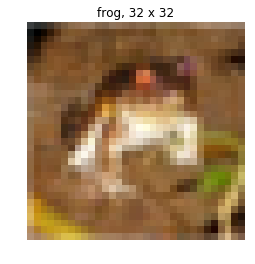

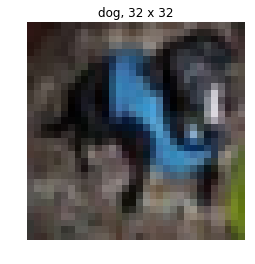

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_relu(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=tf.nn.relu,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=tf.nn.relu,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=tf.nn.relu,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=tf.nn.relu,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
       
        net = slim.conv2d(net, 512, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 512, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/relu1-lrn
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/relu1-lrn/model.ckpt
INFO:tenso

INFO:tensorflow:global step 810: loss = 0.9968 (0.200 sec/step)
INFO:tensorflow:global step 820: loss = 1.1196 (0.198 sec/step)
INFO:tensorflow:global step 830: loss = 0.9945 (0.187 sec/step)
INFO:tensorflow:global step 840: loss = 1.0362 (0.197 sec/step)
INFO:tensorflow:global step 850: loss = 1.0393 (0.190 sec/step)
INFO:tensorflow:global step 860: loss = 1.0264 (0.194 sec/step)
INFO:tensorflow:global step 870: loss = 0.9940 (0.192 sec/step)
INFO:tensorflow:global step 880: loss = 1.0808 (0.205 sec/step)
INFO:tensorflow:global step 890: loss = 1.2212 (0.187 sec/step)
INFO:tensorflow:global step 900: loss = 0.9720 (0.198 sec/step)
INFO:tensorflow:global step 910: loss = 1.0392 (0.203 sec/step)
INFO:tensorflow:global step 920: loss = 0.9100 (0.185 sec/step)
INFO:tensorflow:global step 930: loss = 1.1283 (0.207 sec/step)
INFO:tensorflow:global step 940: loss = 1.1607 (0.186 sec/step)
INFO:tensorflow:global step 950: loss = 1.0070 (0.181 sec/step)
INFO:tensorflow:global step 960: loss = 

INFO:tensorflow:global step 2030: loss = 0.4360 (0.217 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/relu1-lrn/model.ckpt
INFO:tensorflow:global_step/sec: 5.09
INFO:tensorflow:Recording summary at step 2034.
INFO:tensorflow:global step 2040: loss = 0.5159 (0.194 sec/step)
INFO:tensorflow:global step 2050: loss = 0.6183 (0.190 sec/step)
INFO:tensorflow:global step 2060: loss = 0.4907 (0.202 sec/step)
INFO:tensorflow:global step 2070: loss = 0.3813 (0.178 sec/step)
INFO:tensorflow:global step 2080: loss = 0.6199 (0.207 sec/step)
INFO:tensorflow:global step 2090: loss = 0.5211 (0.196 sec/step)
INFO:tensorflow:global step 2100: loss = 0.5764 (0.195 sec/step)
INFO:tensorflow:global step 2110: loss = 0.4182 (0.218 sec/step)
INFO:tensorflow:global step 2120: loss = 0.5998 (0.219 sec/step)
INFO:tensorflow:global step 2130: loss = 0.4433 (0.180 sec/step)
INFO:tensorflow:global step 2140: loss = 0.4793 (0.182 sec/step)
INFO:tensorflow:global step 2150: loss = 0.4248 (0.191 sec

INFO:tensorflow:global step 3220: loss = 0.4324 (0.196 sec/step)
INFO:tensorflow:global step 3230: loss = 0.2358 (0.194 sec/step)
INFO:tensorflow:global step 3240: loss = 0.4762 (0.194 sec/step)
INFO:tensorflow:global step 3250: loss = 0.2108 (0.191 sec/step)
INFO:tensorflow:global step 3260: loss = 0.2137 (0.201 sec/step)
INFO:tensorflow:global step 3270: loss = 0.2903 (0.212 sec/step)
INFO:tensorflow:global step 3280: loss = 0.2234 (0.194 sec/step)
INFO:tensorflow:global step 3290: loss = 0.3109 (0.192 sec/step)
INFO:tensorflow:global step 3300: loss = 0.3036 (0.203 sec/step)
INFO:tensorflow:global step 3310: loss = 0.1939 (0.210 sec/step)
INFO:tensorflow:global step 3320: loss = 0.3486 (0.200 sec/step)
INFO:tensorflow:global step 3330: loss = 0.2161 (0.199 sec/step)
INFO:tensorflow:global step 3340: loss = 0.3162 (0.190 sec/step)
INFO:tensorflow:global step 3350: loss = 0.3080 (0.191 sec/step)
INFO:tensorflow:global step 3360: loss = 0.2062 (0.180 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4440: loss = 0.1240 (0.181 sec/step)
INFO:tensorflow:global step 4450: loss = 0.1224 (0.209 sec/step)
INFO:tensorflow:global step 4460: loss = 0.1265 (0.195 sec/step)
INFO:tensorflow:global step 4470: loss = 0.1268 (0.197 sec/step)
INFO:tensorflow:global step 4480: loss = 0.1279 (0.204 sec/step)
INFO:tensorflow:global step 4490: loss = 0.1594 (0.187 sec/step)
INFO:tensorflow:global step 4500: loss = 0.3044 (0.189 sec/step)
INFO:tensorflow:global step 4510: loss = 0.1910 (0.178 sec/step)
INFO:tensorflow:global step 4520: loss = 0.3702 (0.200 sec/step)
INFO:tensorflow:global step 4530: loss = 0.2819 (0.202 sec/step)
INFO:tensorflow:global step 4540: loss = 0.2176 (0.196 sec/step)
INFO:tensorflow:global step 4550: loss = 0.1791 (0.186 sec/step)
INFO:tensorflow:global step 4560: loss = 0.1006 (0.195 sec/step)
INFO:tensorflow:global step 4570: loss = 0.1125 (0.198 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/relu1-lrn/model.ckpt
INFO:tensorflo

INFO:tensorflow:global step 5640: loss = 0.0791 (0.199 sec/step)
INFO:tensorflow:global step 5650: loss = 0.0693 (0.198 sec/step)
INFO:tensorflow:global step 5660: loss = 0.1045 (0.184 sec/step)
INFO:tensorflow:global step 5670: loss = 0.0494 (0.202 sec/step)
INFO:tensorflow:global step 5680: loss = 0.1232 (0.193 sec/step)
INFO:tensorflow:global step 5690: loss = 0.1462 (0.183 sec/step)
INFO:tensorflow:global step 5700: loss = 0.1094 (0.202 sec/step)
INFO:tensorflow:global step 5710: loss = 0.0813 (0.228 sec/step)
INFO:tensorflow:global step 5720: loss = 0.0852 (0.179 sec/step)
INFO:tensorflow:global step 5730: loss = 0.0984 (0.195 sec/step)
INFO:tensorflow:global step 5740: loss = 0.0499 (0.180 sec/step)
INFO:tensorflow:global step 5750: loss = 0.0209 (0.192 sec/step)
INFO:tensorflow:global step 5760: loss = 0.0425 (0.197 sec/step)
INFO:tensorflow:global step 5770: loss = 0.0706 (0.192 sec/step)
INFO:tensorflow:global step 5780: loss = 0.0579 (0.197 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6870: loss = 0.0648 (0.189 sec/step)
INFO:tensorflow:global step 6880: loss = 0.0312 (0.188 sec/step)
INFO:tensorflow:global step 6890: loss = 0.0784 (0.194 sec/step)
INFO:tensorflow:global step 6900: loss = 0.0834 (0.200 sec/step)
INFO:tensorflow:global step 6910: loss = 0.0705 (0.187 sec/step)
INFO:tensorflow:global step 6920: loss = 0.0222 (0.203 sec/step)
INFO:tensorflow:global step 6930: loss = 0.1403 (0.179 sec/step)
INFO:tensorflow:global step 6940: loss = 0.1764 (0.189 sec/step)
INFO:tensorflow:global step 6950: loss = 0.0478 (0.178 sec/step)
INFO:tensorflow:global step 6960: loss = 0.0899 (0.194 sec/step)
INFO:tensorflow:global step 6970: loss = 0.0902 (0.201 sec/step)
INFO:tensorflow:global step 6980: loss = 0.0460 (0.199 sec/step)
INFO:tensorflow:global step 6990: loss = 0.1367 (0.197 sec/step)
INFO:tensorflow:global step 7000: loss = 0.0828 (0.204 sec/step)
INFO:tensorflow:global step 7010: loss = 0.0560 (0.204 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8100: loss = 0.0558 (0.190 sec/step)
INFO:tensorflow:global step 8110: loss = 0.0986 (0.193 sec/step)
INFO:tensorflow:global step 8120: loss = 0.0127 (0.185 sec/step)
INFO:tensorflow:global step 8130: loss = 0.0125 (0.202 sec/step)
INFO:tensorflow:global step 8140: loss = 0.0251 (0.186 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/relu1-lrn/model.ckpt
INFO:tensorflow:Recording summary at step 8145.
INFO:tensorflow:global step 8150: loss = 0.0394 (0.187 sec/step)
INFO:tensorflow:global step 8160: loss = 0.0244 (0.201 sec/step)
INFO:tensorflow:global step 8170: loss = 0.1138 (0.187 sec/step)
INFO:tensorflow:global step 8180: loss = 0.0382 (0.200 sec/step)
INFO:tensorflow:global step 8190: loss = 0.0756 (0.197 sec/step)
INFO:tensorflow:global step 8200: loss = 0.0849 (0.212 sec/step)
INFO:tensorflow:global step 8210: loss = 0.0510 (0.194 sec/step)
INFO:tensorflow:global step 8220: loss = 0.0566 (0.216 sec/step)
INFO:tensorflow:global step 823

INFO:tensorflow:global step 9310: loss = 0.0499 (0.191 sec/step)
INFO:tensorflow:global step 9320: loss = 0.0505 (0.187 sec/step)
INFO:tensorflow:global step 9330: loss = 0.0890 (0.184 sec/step)
INFO:tensorflow:global step 9340: loss = 0.0086 (0.197 sec/step)
INFO:tensorflow:global step 9350: loss = 0.0933 (0.189 sec/step)
INFO:tensorflow:global step 9360: loss = 0.0382 (0.185 sec/step)
INFO:tensorflow:global step 9370: loss = 0.0340 (0.198 sec/step)
INFO:tensorflow:global step 9380: loss = 0.0097 (0.197 sec/step)
INFO:tensorflow:global step 9390: loss = 0.0831 (0.197 sec/step)
INFO:tensorflow:global step 9400: loss = 0.0180 (0.176 sec/step)
INFO:tensorflow:global step 9410: loss = 0.0553 (0.199 sec/step)
INFO:tensorflow:global step 9420: loss = 0.0216 (0.186 sec/step)
INFO:tensorflow:global step 9430: loss = 0.0289 (0.197 sec/step)
INFO:tensorflow:global step 9440: loss = 0.0590 (0.199 sec/step)
INFO:tensorflow:global step 9450: loss = 0.0163 (0.196 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 10530: loss = 0.0121 (0.189 sec/step)
INFO:tensorflow:global step 10540: loss = 0.0067 (0.192 sec/step)
INFO:tensorflow:global step 10550: loss = 0.0363 (0.200 sec/step)
INFO:tensorflow:global step 10560: loss = 0.0193 (0.190 sec/step)
INFO:tensorflow:global step 10570: loss = 0.0321 (0.208 sec/step)
INFO:tensorflow:global step 10580: loss = 0.0900 (0.194 sec/step)
INFO:tensorflow:global step 10590: loss = 0.0475 (0.187 sec/step)
INFO:tensorflow:global step 10600: loss = 0.1254 (0.198 sec/step)
INFO:tensorflow:global step 10610: loss = 0.0911 (0.191 sec/step)
INFO:tensorflow:global step 10620: loss = 0.0574 (0.185 sec/step)
INFO:tensorflow:global step 10630: loss = 0.1127 (0.196 sec/step)
INFO:tensorflow:global step 10640: loss = 0.0307 (0.206 sec/step)
INFO:tensorflow:global step 10650: loss = 0.0459 (0.196 sec/step)
INFO:tensorflow:global step 10660: loss = 0.0228 (0.197 sec/step)
INFO:tensorflow:global step 10670: loss = 0.0698 (0.198 sec/step)
INFO:tenso

INFO:tensorflow:global step 11720: loss = 0.0130 (0.184 sec/step)
INFO:tensorflow:global step 11730: loss = 0.0799 (0.199 sec/step)
INFO:tensorflow:global step 11740: loss = 0.0492 (0.193 sec/step)
INFO:tensorflow:global step 11750: loss = 0.0403 (0.202 sec/step)
INFO:tensorflow:global step 11760: loss = 0.0282 (0.191 sec/step)
INFO:tensorflow:global step 11770: loss = 0.0154 (0.195 sec/step)
INFO:tensorflow:global step 11780: loss = 0.0417 (0.190 sec/step)
INFO:tensorflow:global step 11790: loss = 0.0657 (0.205 sec/step)
INFO:tensorflow:global step 11800: loss = 0.0341 (0.205 sec/step)
INFO:tensorflow:global step 11810: loss = 0.0287 (0.199 sec/step)
INFO:tensorflow:global step 11820: loss = 0.1656 (0.234 sec/step)
INFO:tensorflow:global step 11830: loss = 0.0814 (0.190 sec/step)
INFO:tensorflow:global step 11840: loss = 0.0773 (0.187 sec/step)
INFO:tensorflow:global step 11850: loss = 0.0695 (0.183 sec/step)
INFO:tensorflow:global step 11860: loss = 0.0306 (0.204 sec/step)
INFO:tenso

INFO:tensorflow:global step 12930: loss = 0.0178 (0.194 sec/step)
INFO:tensorflow:global step 12940: loss = 0.0378 (0.197 sec/step)
INFO:tensorflow:global step 12950: loss = 0.0132 (0.212 sec/step)
INFO:tensorflow:global step 12960: loss = 0.0267 (0.199 sec/step)
INFO:tensorflow:global step 12970: loss = 0.0486 (0.197 sec/step)
INFO:tensorflow:global step 12980: loss = 0.0486 (0.189 sec/step)
INFO:tensorflow:global step 12990: loss = 0.0404 (0.188 sec/step)
INFO:tensorflow:global step 13000: loss = 0.0242 (0.194 sec/step)
INFO:tensorflow:global step 13010: loss = 0.0445 (0.179 sec/step)
INFO:tensorflow:global step 13020: loss = 0.1000 (0.206 sec/step)
INFO:tensorflow:global step 13030: loss = 0.0291 (0.187 sec/step)
INFO:tensorflow:global step 13040: loss = 0.0349 (0.198 sec/step)
INFO:tensorflow:global step 13050: loss = 0.0390 (0.202 sec/step)
INFO:tensorflow:global step 13060: loss = 0.0128 (0.201 sec/step)
INFO:tensorflow:global step 13070: loss = 0.0067 (0.206 sec/step)
INFO:tenso

INFO:tensorflow:global step 14140: loss = 0.0721 (0.188 sec/step)
INFO:tensorflow:global step 14150: loss = 0.0579 (0.196 sec/step)
INFO:tensorflow:global step 14160: loss = 0.0152 (0.196 sec/step)
INFO:tensorflow:global step 14170: loss = 0.0458 (0.192 sec/step)
INFO:tensorflow:global step 14180: loss = 0.0056 (0.193 sec/step)
INFO:tensorflow:global step 14190: loss = 0.0567 (0.188 sec/step)
INFO:tensorflow:global step 14200: loss = 0.0448 (0.200 sec/step)
INFO:tensorflow:global step 14210: loss = 0.0177 (0.188 sec/step)
INFO:tensorflow:global step 14220: loss = 0.0141 (0.186 sec/step)
INFO:tensorflow:global step 14230: loss = 0.0651 (0.189 sec/step)
INFO:tensorflow:global step 14240: loss = 0.0190 (0.188 sec/step)
INFO:tensorflow:global step 14250: loss = 0.0238 (0.185 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/relu1-lrn/model.ckpt
INFO:tensorflow:Recording summary at step 14259.
INFO:tensorflow:global step 14260: loss = 0.0070 (0.295 sec/step)
INFO:tensorflow:g

INFO:tensorflow:global step 15330: loss = 0.0040 (0.190 sec/step)
INFO:tensorflow:global step 15340: loss = 0.0075 (0.191 sec/step)
INFO:tensorflow:global step 15350: loss = 0.0117 (0.196 sec/step)
INFO:tensorflow:global step 15360: loss = 0.0106 (0.200 sec/step)
INFO:tensorflow:global step 15370: loss = 0.0747 (0.193 sec/step)
INFO:tensorflow:global step 15380: loss = 0.0030 (0.202 sec/step)
INFO:tensorflow:global step 15390: loss = 0.0201 (0.195 sec/step)
INFO:tensorflow:global step 15400: loss = 0.0364 (0.183 sec/step)
INFO:tensorflow:global step 15410: loss = 0.0093 (0.193 sec/step)
INFO:tensorflow:global step 15420: loss = 0.0028 (0.201 sec/step)
INFO:tensorflow:global step 15430: loss = 0.0403 (0.192 sec/step)
INFO:tensorflow:global step 15440: loss = 0.0380 (0.207 sec/step)
INFO:tensorflow:global step 15450: loss = 0.0062 (0.189 sec/step)
INFO:tensorflow:global step 15460: loss = 0.0411 (0.191 sec/step)
INFO:tensorflow:global step 15470: loss = 0.0250 (0.185 sec/step)
INFO:tenso

INFO:tensorflow:global step 16540: loss = 0.0473 (0.189 sec/step)
INFO:tensorflow:global step 16550: loss = 0.0004 (0.179 sec/step)
INFO:tensorflow:global step 16560: loss = 0.0262 (0.200 sec/step)
INFO:tensorflow:global step 16570: loss = 0.0090 (0.188 sec/step)
INFO:tensorflow:global step 16580: loss = 0.0179 (0.196 sec/step)
INFO:tensorflow:global step 16590: loss = 0.0560 (0.194 sec/step)
INFO:tensorflow:global step 16600: loss = 0.0018 (0.185 sec/step)
INFO:tensorflow:global step 16610: loss = 0.0067 (0.185 sec/step)
INFO:tensorflow:global step 16620: loss = 0.0122 (0.199 sec/step)
INFO:tensorflow:global step 16630: loss = 0.0271 (0.198 sec/step)
INFO:tensorflow:global step 16640: loss = 0.0301 (0.192 sec/step)
INFO:tensorflow:global step 16650: loss = 0.0118 (0.199 sec/step)
INFO:tensorflow:global step 16660: loss = 0.0444 (0.202 sec/step)
INFO:tensorflow:global step 16670: loss = 0.0365 (0.193 sec/step)
INFO:tensorflow:global step 16680: loss = 0.0601 (0.191 sec/step)
INFO:tenso

INFO:tensorflow:global step 17750: loss = 0.0030 (0.193 sec/step)
INFO:tensorflow:global step 17760: loss = 0.0491 (0.191 sec/step)
INFO:tensorflow:global step 17770: loss = 0.0244 (0.192 sec/step)
INFO:tensorflow:global step 17780: loss = 0.0108 (0.204 sec/step)
INFO:tensorflow:global step 17790: loss = 0.0356 (0.197 sec/step)
INFO:tensorflow:global step 17800: loss = 0.0047 (0.195 sec/step)
INFO:tensorflow:global step 17810: loss = 0.0071 (0.202 sec/step)
INFO:tensorflow:global step 17820: loss = 0.0267 (0.191 sec/step)
INFO:tensorflow:global step 17830: loss = 0.0121 (0.200 sec/step)
INFO:tensorflow:global step 17840: loss = 0.0710 (0.204 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/relu1-lrn/model.ckpt
INFO:tensorflow:Recording summary at step 17847.
INFO:tensorflow:global step 17850: loss = 0.0393 (0.198 sec/step)
INFO:tensorflow:global step 17860: loss = 0.0385 (0.229 sec/step)
INFO:tensorflow:global step 17870: loss = 0.0253 (0.196 sec/step)
INFO:tensorflow:g

INFO:tensorflow:global step 18940: loss = 0.0047 (0.194 sec/step)
INFO:tensorflow:global step 18950: loss = 0.1547 (0.225 sec/step)
INFO:tensorflow:global step 18960: loss = 0.0565 (0.198 sec/step)
INFO:tensorflow:global step 18970: loss = 0.0634 (0.195 sec/step)
INFO:tensorflow:global step 18980: loss = 0.0330 (0.197 sec/step)
INFO:tensorflow:global step 18990: loss = 0.0018 (0.196 sec/step)
INFO:tensorflow:global step 19000: loss = 0.0138 (0.188 sec/step)
INFO:tensorflow:global step 19010: loss = 0.0715 (0.198 sec/step)
INFO:tensorflow:global step 19020: loss = 0.0062 (0.183 sec/step)
INFO:tensorflow:global step 19030: loss = 0.0123 (0.196 sec/step)
INFO:tensorflow:global step 19040: loss = 0.0484 (0.186 sec/step)
INFO:tensorflow:global step 19050: loss = 0.0064 (0.199 sec/step)
INFO:tensorflow:global step 19060: loss = 0.0055 (0.196 sec/step)
INFO:tensorflow:global step 19070: loss = 0.0153 (0.197 sec/step)
INFO:tensorflow:global step 19080: loss = 0.0603 (0.205 sec/step)
INFO:tenso

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-03-16:23:31
INFO:tensorflow:Restoring parameters from /tmp/cifar10/relu1-lrn/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-16:23:32
eval/Accuracy: 0.828125
eval/FalsePositives: 2.000000
eval/Recall5: 0.984375
eval/FalseNegatives: 0.000000
eval/mse: 2.015625
eval/TrueNegatives: 10.000000
eval/TruePositives: 116.000000
CPU times: user 1.54 s, sys: 352 ms, total: 1.89 s
Wall time: 1.15 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/relu1-lrn/model.ckpt-20000


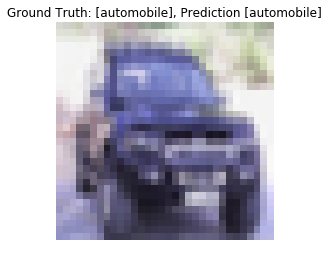

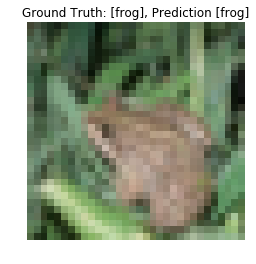

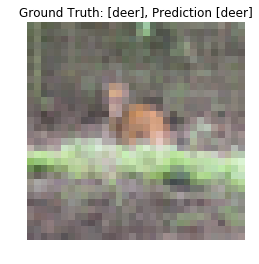

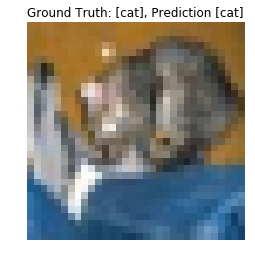

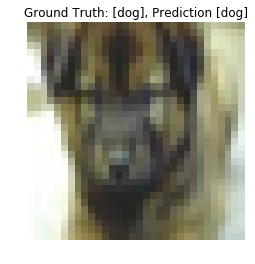

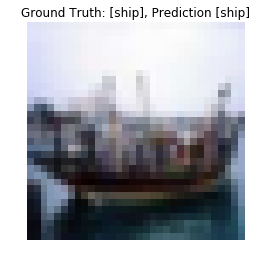

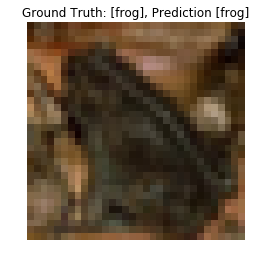

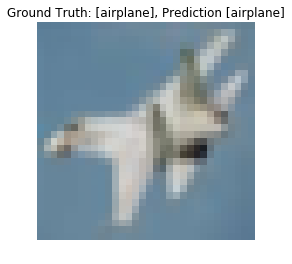

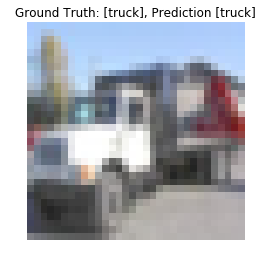

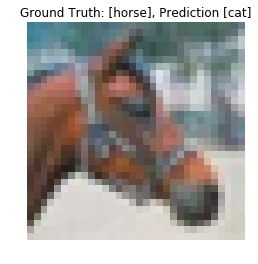

CPU times: user 3.38 s, sys: 1.82 s, total: 5.2 s
Wall time: 1.69 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()